# Using Class Supplied Sentiment Class to Predict Sentiment of Future Reviews

## Data Evaluation and Preprocessing

In [1]:
# General Data Manipulation / EDA
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sb
from os.path import join
from collections import Counter, OrderedDict

# Natural Language Processing
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
import gensim
from sklearn.model_selection import train_test_split # Since our data is independent and not time related

# Machine Learning
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
import tensorflow as tf
tf.random.set_seed(42)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Dropout
from tensorflow.keras.preprocessing import sequence

from sklearn.metrics import roc_auc_score

BOOK_REVIEWS_PATH = join("data", "bookReviewsData.csv")
SCRAPED_REVIEWS_PATH = join("data", "embed_reviews.csv")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
def make_border(txt):
  print()
  print("-"*10, txt.upper(), "-"*10)

### Examining the Raw Data

In [3]:
raw_df = pd.read_csv(BOOK_REVIEWS_PATH)
raw_df.columns = ["text", "sentiment"]
make_border("Checking CSV")
raw_df.info()


---------- CHECKING CSV ----------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1973 entries, 0 to 1972
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text       1973 non-null   object
 1   sentiment  1973 non-null   bool  
dtypes: bool(1), object(1)
memory usage: 17.5+ KB


In [4]:
make_border("Checking Null Values")
print(raw_df.isna().sum())
make_border("Checking for Blank Reviews")
raw_df.loc[raw_df.text == ""]


---------- CHECKING NULL VALUES ----------
text         0
sentiment    0
dtype: int64

---------- CHECKING FOR BLANK REVIEWS ----------


,text,sentiment



---------- CHECKING CLASS BALANCE ----------
False    993
True     980
Name: sentiment, dtype: int64 



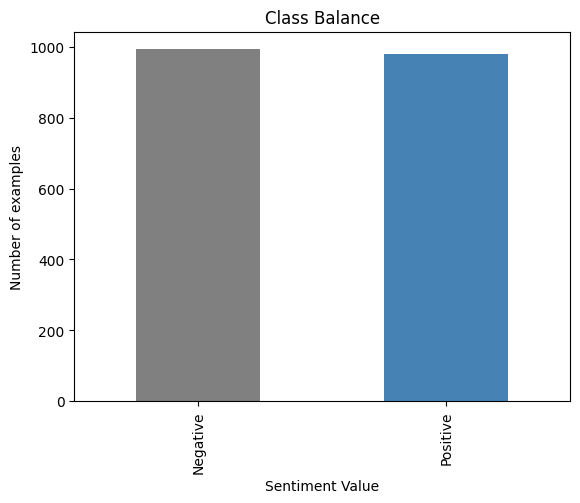

In [5]:
make_border("Checking Class Balance")
print(raw_df.sentiment.value_counts(), "\n")
raw_df.sentiment.value_counts().plot.bar(title="Class Balance", ylabel="Number of examples", xlabel="Sentiment Value",
                                         color=["grey", "steelblue"])
plt.xticks([0,1], labels=["Negative", "Positive"])
plt.show()


---------- CHECKING NUMBER OF LETTERS IN EACH ROW ----------
count     1973.000000
mean       933.336036
std       1450.187183
min         59.000000
25%        331.000000
50%        586.000000
75%       1065.000000
max      32467.000000
Name: text, dtype: float64



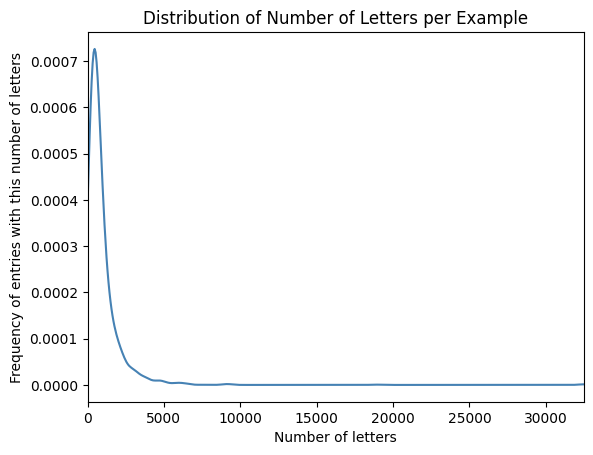

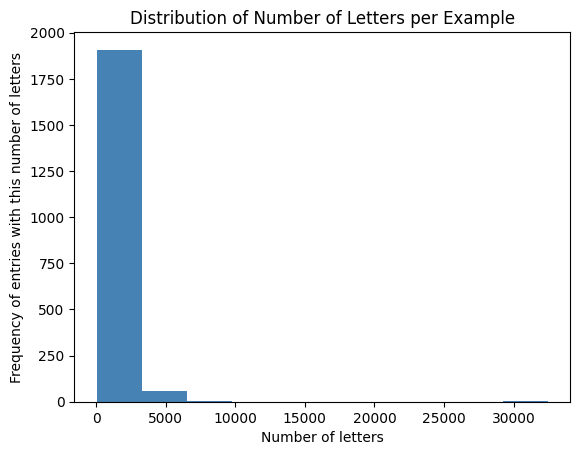

In [6]:
entry_lengths = raw_df.text.map(lambda x: len(x))
make_border("Checking number of letters in each row")
print(entry_lengths.describe())
print()
entry_lengths.plot.density(title="Distribution of Number of Letters per Example",
                           color="steelblue")
plt.xlabel("Number of letters")
plt.ylabel("Frequency of entries with this number of letters")
plt.xlim(left=0, right=entry_lengths.max())
plt.show()
print()
entry_lengths.plot.hist(title="Distribution of Number of Letters per Example",
                           color="steelblue")
plt.xlabel("Number of letters")
plt.ylabel("Frequency of entries with this number of letters")
plt.show()

In [7]:
raw_df["text_stripped"] = raw_df.text.map(lambda row: [w for w in row.lower().split(" ") if w != "" and w.isalpha()])
raw_df.text_stripped

0       [this, was, perhaps, the, best, of, johannes, ...
1       [this, very, fascinating, book, is, a, story, ...
2       [the, four, tales, in, this, collection, are, ...
3       [the, book, contained, more, profanity, than, ...
4       [we, have, now, entered, a, second, time, of, ...
                              ...                        
1968    [i, purchased, the, book, with, the, intention...
1969    [there, are, so, many, design, but, the, graph...
1970    [i, am, thilled, to, see, this, book, being, a...
1971    [as, many, have, stated, before, me, the, book...
1972    [i, love, this, it, is, a, terrific, blend, of...
Name: text_stripped, Length: 1973, dtype: object

In [8]:
make_border("Checking Top Vocab Overall")

print("You'll notice the top words are typically stop words.")

print("The plan is to compare TF-IDF and  word embedding, so we don't have to remove these. TF-IDF and word embedding have built-in ways of minimizing the disproportionate impact of stop words.")

text_count = {}

for row in raw_df.text_stripped.values:
  for k, v in dict(Counter(row)).items():
    if k in text_count:
      text_count[k] += v
    else:
      text_count[k] = v

text_count = {k:v for k, v in sorted(text_count.items(), key=lambda t: t[1], reverse=True)}

for i, w in enumerate(list(text_count.items())[:100]):
  print(f"{i+1}. {w[0]} ({w[1]:,})")


---------- CHECKING TOP VOCAB OVERALL ----------
You'll notice the top words are typically stop words.
The plan is to compare TF-IDF and  word embedding, so we don't have to remove these. TF-IDF and word embedding have built-in ways of minimizing the disproportionate impact of stop words.
1. the (16,410)
2. of (9,325)
3. and (8,924)
4. to (8,489)
5. a (7,776)
6. is (5,416)
7. in (5,066)
8. i (4,935)
9. this (4,198)
10. that (3,854)
11. it (3,364)
12. book (3,064)
13. for (2,790)
14. with (2,237)
15. as (2,218)
16. was (2,083)
17. not (1,987)
18. are (1,879)
19. but (1,842)
20. on (1,763)
21. you (1,700)
22. have (1,624)
23. he (1,517)
24. be (1,515)
25. his (1,495)
26. or (1,229)
27. by (1,187)
28. about (1,178)
29. an (1,149)
30. from (1,144)
31. one (1,063)
32. at (1,022)
33. my (1,005)
34. all (996)
35. if (995)
36. who (984)
37. has (918)
38. so (918)
39. read (909)
40. what (874)
41. they (860)
42. more (854)
43. her (817)
44. would (801)
45. like (765)
46. just (736)
47. very (7

### Creating Features using TF-IDF / Word Embedding

In [9]:
X = raw_df.text
y = raw_df.sentiment
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.75, random_state=42)

In [10]:
tfidf = TfidfVectorizer(tokenizer=word_tokenize, token_pattern=None, ngram_range=(1,3))
tfidf.fit(X_train)
X_train_tf = tfidf.transform(X_train)
X_test_tf = tfidf.transform(X_test)

In [11]:
# reviews_df = pd.read_csv(SCRAPED_REVIEWS_PATH)
# reviews_df.text = reviews_df.text.map(lambda row: gensim.utils.simple_preprocess(row))
reviews_df = raw_df.copy()
reviews_df.text = reviews_df.text.map(lambda row: gensim.utils.simple_preprocess(row))
word2vec_model = gensim.models.Word2Vec(reviews_df.text,
                                   vector_size=100,
                                   window=5,
                                   min_count=2)
words = set(word2vec_model.wv.index_to_key)

X_train_we = np.array([np.array([word2vec_model.wv[word] for word in words if word in training_example])
                        for training_example in X_train], dtype=object)
X_test_we = np.array([np.array([word2vec_model.wv[word] for word in words if word in training_example])
                        for training_example in X_test], dtype=object)

X_train_fv = []
for w in X_train_we:
    if w.size:
        X_train_fv.append(w.mean(axis=0))
    else:
        X_train_fv.append(np.zeros(100, dtype=float))

X_test_fv = []
for w in X_test_we:
    if w.size:
        X_test_fv.append(w.mean(axis=0))
    else:
        X_test_fv.append(np.zeros(100, dtype=float))

## Logistic Regression

In [12]:
lr_model_tf = LogisticRegression(max_iter=200)
lr_model_tf.fit(X_train_tf, y_train)
lr_pred_tf = lr_model_tf.predict_proba(X_test_tf)[:,1]

lr_auc_tf = roc_auc_score(y_test, lr_pred_tf)
make_border("Logistic Regression (TF-IDF) AUC")
print(f"{lr_auc_tf:.2f}")


---------- LOGISTIC REGRESSION (TF-IDF) AUC ----------
0.83


In [13]:
lr_model_em = LogisticRegression(max_iter=200)
lr_model_em.fit(X_train_fv, y_train)
lr_pred_em = lr_model_em.predict_proba(X_test_fv)[:,1]

lr_auc_em = roc_auc_score(y_test, lr_pred_em)
make_border("Logistic Regression (WORD EMBED) AUC")
print(f"{lr_auc_em:.2f}")


---------- LOGISTIC REGRESSION (WORD EMBED) AUC ----------
0.62


## Naive Bayes

In [14]:
nb_model_tf = GaussianNB()
nb_model_tf.fit(X_train_tf.toarray(), y_train)
nb_pred_tf = nb_model_tf.predict(X_test_tf.toarray())

nb_auc_tf = roc_auc_score(y_test, nb_pred_tf)
make_border("Gaussian Naive Bayes (TF-IDF) AUC")
print(f"{nb_auc_tf:.2f}")


---------- GAUSSIAN NAIVE BAYES (TF-IDF) AUC ----------
0.68


In [15]:
nb_model_em = GaussianNB()
nb_model_em.fit(X_train_fv, y_train)
nb_pred_em = nb_model_em.predict(X_test_fv)

nb_auc_em = roc_auc_score(y_test, nb_pred_em)
make_border("Gaussian Naive Bayes (WORD EMEBD) AUC")
print(f"{nb_auc_em:.2f}")


---------- GAUSSIAN NAIVE BAYES (WORD EMEBD) AUC ----------
0.57


## Random Forest Classifier

In [16]:
rf_model_tf = RandomForestClassifier()
rf_model_tf.fit(X_train_tf, y_train)
rf_pred_tf = rf_model_tf.predict(X_test_tf)

rf_auc_tf = roc_auc_score(y_test, rf_pred_tf)
make_border("Random Forest Classifier (TF-IDF) AUC")
print(f"{rf_auc_tf:.2f}")


---------- RANDOM FOREST CLASSIFIER (TF-IDF) AUC ----------
0.73


In [17]:
rf_model_em = RandomForestClassifier()
rf_model_em.fit(X_train_fv, y_train)
rf_pred_em = rf_model_em.predict(X_test_fv)

rf_auc_em = roc_auc_score(y_test, rf_pred_em)
make_border("Random Forest Classifier (WORD EMBED) AUC")
print(f"{rf_auc_em:.2f}")


---------- RANDOM FOREST CLASSIFIER (WORD EMBED) AUC ----------
0.61


## LSTM Neural Network

In [18]:
max_review_length = 500
top_words = 5000
embedding_vector_length = 32

X_train_fv_nn = sequence.pad_sequences(X_train_fv, maxlen=max_review_length)
X_test_fv_nn = sequence.pad_sequences(X_test_fv, maxlen=max_review_length)

In [31]:
lstm_model = Sequential()
lstm_model.add(Embedding(top_words, embedding_vector_length, input_length=max_review_length))
# lstm_model.add(Dropout(0.35))
lstm_model.add(LSTM(700))
# lstm_model.add(Dropout(0.2))
lstm_model.add(Dense(1, activation="sigmoid"))
lstm_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 500, 32)           160000    
                                                                 
 lstm_4 (LSTM)               (None, 700)               2052400   
                                                                 
 dense_4 (Dense)             (None, 1)                 701       
                                                                 
Total params: 2,213,101
Trainable params: 2,213,101
Non-trainable params: 0
_________________________________________________________________


In [32]:
lstm_model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["AUC"])

In [ ]:
lstm_model.fit(X_train_fv_nn, y_train, epochs=10)

Epoch 1/10
16/16 [==============================] - 153s 9s/step - loss: 0.7008 - auc: 0.4866
Epoch 2/10
16/16 [==============================] - 149s 9s/step - loss: 0.6934 - auc: 0.4722
Epoch 3/10
 6/16 [==========>...................] - ETA: 1:36 - loss: 0.6930 - auc: 0.5000

In [28]:
lstm_eval = lstm_model.evaluate(X_test_fv_nn, y_test, verbose=0)
make_border("LSTM (WORD EMBED) AUC")
lstm_eval[1]


---------- LSTM (WORD EMBED) AUC ----------


0.5